# Imports

In [ ]:
!nvidia-smi

Tue Nov 29 21:53:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers --quiet
!pip install sentencepiece --quiet

     |████████████████████████████████| 5.5 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 81.5 MB/s 
     |████████████████████████████████| 182 kB 69.2 MB/s 
     |████████████████████████████████| 1.3 MB 4.7 MB/s 


In [ ]:
import os
import sys
import time
import string
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, \
  LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer
from transformers import BertConfig, BertTokenizer, TFBertModel
import transformers

## Global Variables and Google Drive Connect

In [ ]:
TESTING = False # use to truncate training data in order to speed up development

RANDOM_STATE = 42
SEQUENCE_LENGTH = 512
BATCH_SIZE = 1
USER = 'HIDDEN'
RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
PATIENCE = 2
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = 0.1
EPOCHS = 6
PRETRAINED_MODEL = "bert-large-cased" # "bert-base-cased"
# Uncomment these two lines if you want to be able to be able to repeat calculations exactly on the same hardware
# However, the model will run more slowly (approx 1/3 speed)
# tf.keras.utils.set_random_seed(RANDOM_STATE)
# tf.config.experimental.enable_op_determinism()

In [ ]:
drive.mount('/content/drive')
root_dir = "NOT SHOW FOR PRIVACY PURPOSES"
project_folder = "NOT SHOW FOR PRIVACY PURPOSES"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # to test if all is working, you can uncomment these two lines below--it should write a file to the shared drive
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Load Data and Create Data Sets

In [ ]:
#Pull training data with all columns
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')

#pull validation data with all columns 
X_val = pd.read_csv('data/processed/X_val.csv')
y_val = pd.read_csv('data/processed/y_val.csv')

#pull test data with all columns
# X_test = pd.read_csv('data/processed/X_test.csv')
# y_test = pd.read_csv('data/processed/y_test.csv')

#drop all non-text columns and concatenate train and val into one dataset
train_data = pd.merge(X_train, y_train, on='essay_index', how='outer')
validation_data = pd.merge(X_val, y_val, on='essay_index', how='outer')

#create train set
train_data = train_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
train_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#create val set
val_data = validation_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
val_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

print("train data size is: {}".format(train_data.shape))
print("test size is: {}".format(val_data.shape))

train data size is: (2347, 7)
test size is: (782, 7)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
if TESTING:
  train_size = 250
  val_size = 3

  print("=========================================\nIN TESTING MODE\n=========================================")

else:
  train_size = 2347
  val_size = 782

train_data = train_data[:train_size]
val_data = val_data[:val_size]

print("input_data size is: {}".format(train_data.shape))
print("validation data size is: {}".format(val_data.shape))

input_data size is: (2347, 7)
validation data size is: (782, 7)


## Tokenize Data

In [ ]:
bert_model = transformers.TFAutoModel.from_pretrained(PRETRAINED_MODEL) # changed from deberta_base_fresh
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(PRETRAINED_MODEL) # changed from deberta_base_fresh

auto_tune = tf.data.experimental.AUTOTUNE

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def bert_encode(texts, tokenizer, attn_mask):
    """
    Encodes the given texts using the provided tokenizer and returns the input
    IDs and attention mask.

    Args:
    - texts (list of str): A list of strings representing the texts to be
    encoded.
    - tokenizer (TensorFlow tokenizer): An instance of a tokenizer to be used
    for tokenization.
    - attn_mask (array): A boolean indicating whether to include the attention
    mask in the output.

    Returns:
    - input_ids: A NumPy array of shape (n_texts, max_sequence_length)
    representing the input IDs of the encoded texts.
    - attention_mask: A NumPy array of shape (n_texts, max_sequence_length)
    representing the attention mask of the encoded texts, if attn_mask=True.
    """ 

    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=SEQUENCE_LENGTH, 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    if attn_mask:
        return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")
    else:
        return np.array(input_ids, dtype="int32")


def get_data(df, attn_mask=True):
    inputs = bert_encode(df['full_text'], bert_tokenizer, attn_mask)  # changed
    targets = np.array(df[RUBRIC_COLS], dtype="float32")
    return inputs, targets

In [ ]:
train_dataset = get_data(train_data)
val_dataset = get_data(val_data)

# Loss and Metrics Functions

In [ ]:
# Using Huber loss which is less sensitive to outliers/edge cases
def huber_loss(y_true, y_pred, clip_delta=1.0):
    """
    Find the Huber loss between the true values and predicted values

    Arguments:
    - y_true: A tensor or array of true values.
    - y_pred: A tensor or array of predicted values.
    - clip_delta: A float representing the threshold for the absolute error.
    If the absolute error is below this threshold, squared loss is applied,
    otherwise, linear loss is applied.

    Returns:
    - A tensor representing the Huber loss between the true and predicted
    values.
    """

    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)

keras.losses.huber_loss = huber_loss

In [ ]:
def MCRMSE(y_true, y_pred):
    """
    Find mean column wise root mean squared error given arrays of true
    labels and predictions
    """
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# Callbacks and LR 

In [ ]:
#early stopping
earlystopper = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience = PATIENCE,
      restore_best_weights=True)

In [ ]:
#learning rate schedule
def lr_scheduler(epoch, lr):
    """Learning rate scheduler"""
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Model Configuration

In [ ]:
base_bert_config = dict(
    RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
                   'phraseology', 'grammar', 'conventions'],
    batch_size = BATCH_SIZE,
    model_name = 'base_bert',
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = [MCRMSE],
    earlystopping_patience = PATIENCE
)

In [ ]:
cfg = transformers.AutoConfig.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True) # Changed from deberta_base_fresh
cfg.hidden_dropout_prob = 0
cfg.attention_probs_dropout_prob = 0
# cfg.save_pretrained('./tokenizer/')

In [ ]:
def create_bert_model(bert_model,
                      hidden_size = 100, 
                      dropout = 0.0):
    """
    Create BERT model with gloval averaging pooling and layer normalization
    
    Args:
    - bert_model (BERT model): A pre-trained BERT model.
    - hidden_size (int) : An integer representing the size of the hidden layer.
    - dropout (float): A float representing the dropout rate.

    Returns:
    - A compiled TensorFlow Keras model that takes input IDs and attention masks,
    and outputs a prediction for the six analytic measures.
    """

    
    # Read in bert model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks
    )
    hidden_states = bert_output.last_hidden_state

    x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
    x = tf.keras.layers.LayerNormalization()(x)

    # Prediction layer - predict all 6 analytic measures
    output = tf.keras.layers.Dense(6, name='prediction_layer')(x)

    # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=MCRMSE)
       
    return model

# Building Model

In [ ]:
#ex 1
tf.keras.backend.clear_session()

bert_model = transformers.TFAutoModel.from_pretrained(PRETRAINED_MODEL, config=cfg)
bert_pooled_model = create_bert_model(bert_model,
                                                 train_layers = -1,
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

tf.keras.backend.clear_session()

gc.collect()

Some layers from the model checkpoint at bert-large-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


45436

# Training and Evaluate Model

In [ ]:
def train_model(model,
                train_df,
                val_df,
                config: dict,
                callbacks: list,
                verbose: int=0):
    
    """
    Fit created BERT model using training and validation sets
    """
    
    # Initalize model
    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = PATIENCE , restore_best_weights=True)

    model_history = model.fit(
      x=train_df[0],
      y=train_df[1],
      validation_data = val_df,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      shuffle = True, 
      callbacks = [callback]
      )

    return model_history

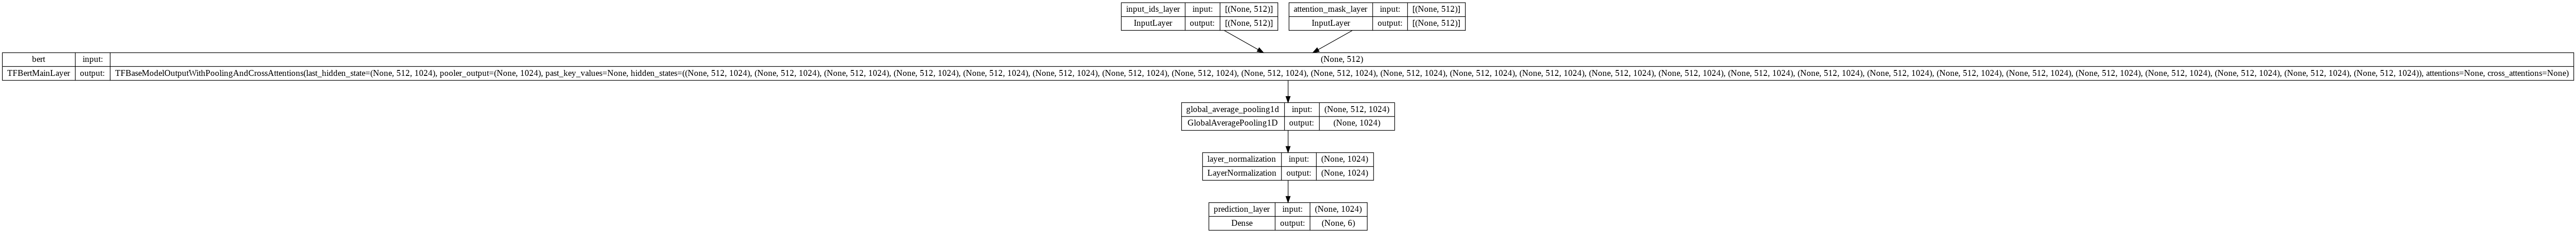

In [ ]:
plot_model(bert_pooled_model, show_shapes=True, show_layer_names=True)

In [ ]:
bert_pooled_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  333579264   ['input_ids_layer[0][0]',        
                                thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [ ]:
%%time
callbacks = [earlystopper]

tf.keras.backend.clear_session()

db_last_hidden_model = train_model(model=bert_pooled_model,
                        train_df = train_dataset, 
                         val_df = val_dataset, 
                         config=base_bert_config, 
                         callbacks=callbacks, 
                         verbose=1)

tf.keras.backend.clear_session()

Epoch 1/6


2347/2347 [==============================] - 185s 70ms/step - loss: 0.1609 - MCRMSE: 0.4539 - val_loss: 0.1135 - val_MCRMSE: 0.3845
Epoch 2/6
2347/2347 [==============================] - 161s 69ms/step - loss: 0.1145 - MCRMSE: 0.3846 - val_loss: 0.1140 - val_MCRMSE: 0.3850
Epoch 3/6
2347/2347 [==============================] - 161s 69ms/step - loss: 0.0865 - MCRMSE: 0.3315 - val_loss: 0.1255 - val_MCRMSE: 0.4061
Epoch 4/6
2347/2347 [==============================] - 161s 69ms/step - loss: 0.0681 - MCRMSE: 0.2950 - val_loss: 0.1190 - val_MCRMSE: 0.3923
Epoch 5/6
2347/2347 [==============================] - 161s 68ms/step - loss: 0.0576 - MCRMSE: 0.2713 - val_loss: 0.1160 - val_MCRMSE: 0.3873
Epoch 6/6
2347/2347 [==============================] - 161s 68ms/step - loss: 0.0418 - MCRMSE: 0.2299 - val_loss: 0.1197 - val_MCRMSE: 0.3924
CPU times: user 17min 11s, sys: 19.6 s, total: 17min 30s
Wall time: 16min 29s


## Validation loss: ~0.385, overfitting training set